In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime

Using TensorFlow backend.


In [2]:
dataset = read_csv("wind.csv",
                   parse_dates={'dt' : ['Time']},
                   infer_datetime_format=True, 
                   index_col= 0,
                   na_values=['nan','?'])
dataset.fillna(0, inplace=True)
values = dataset.values
# ensure all data is float
values = values.astype('float32')

In [3]:
dataset.head(4)

,Unnamed: 0,temp(degrees),dewPoint,humidity,pressure,windSpeed,Month,windspeed45,windspeed
dt,,,,,,,,,
2015-01-01 00:00:00,0,13.177778,41.18,0.58,1015.27,4.91,1,491,2.194966
2015-01-01 01:00:00,1,12.572222,40.44,0.59,1015.21,5.80,1,580,2.592832
2015-01-01 02:00:00,2,12.050000,39.44,0.58,1015.01,6.52,1,652,2.914701
2015-01-01 03:00:00,3,11.666667,39.06,0.59,1014.80,7.00,1,700,3.129280


In [4]:
dataset.drop(columns  = [ 'dewPoint', 'Month', 'windspeed45', 'windSpeed'], inplace = True)

In [5]:
dataset.head()

,Unnamed: 0,temp(degrees),humidity,pressure,windspeed
dt,,,,,
2015-01-01 00:00:00,0,13.177778,0.58,1015.27,2.194966
2015-01-01 01:00:00,1,12.572222,0.59,1015.21,2.592832
2015-01-01 02:00:00,2,12.050000,0.58,1015.01,2.914701
2015-01-01 03:00:00,3,11.666667,0.59,1014.80,3.129280
2015-01-01 04:00:00,4,11.450000,0.62,1014.52,3.236570


In [6]:
dataset.drop(columns = 'Unnamed: 0', inplace = True)

In [7]:
#final dataset
dataset.head()

,temp(degrees),humidity,pressure,windspeed
dt,,,,
2015-01-01 00:00:00,13.177778,0.58,1015.27,2.194966
2015-01-01 01:00:00,12.572222,0.59,1015.21,2.592832
2015-01-01 02:00:00,12.050000,0.58,1015.01,2.914701
2015-01-01 03:00:00,11.666667,0.59,1014.80,3.129280
2015-01-01 04:00:00,11.450000,0.62,1014.52,3.236570


In [8]:
values = dataset.values
# ensure all data is float
values = values.astype('float32')

In [9]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled =pd.DataFrame(scaled)

In [10]:
scaled.head(4)

,0,1,2,3
0,0.230050,0.553191,0.720556,0.266125
1,0.215052,0.563830,0.718824,0.314363
2,0.202119,0.553191,0.713049,0.353388
3,0.192625,0.563830,0.706987,0.379404


In [11]:
def create_ts_data(dataset, lookback=1, predicted_col=3):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    #final_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)','var1(t)']
    #final_df.set_index('Date', inplace=True)
    return final_df

In [12]:
#We now create the time series dataset with looking back one time step

reframed_df= create_ts_data(scaled, 1,3)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',]
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)
id                                                       
1    0.230050   0.553191   0.720556   0.266125   0.314363
2    0.215052   0.563830   0.718824   0.314363   0.353388
3    0.202119   0.553191   0.713049   0.353388   0.379404
4    0.192625   0.563830   0.706987   0.379404   0.392412


In [13]:
# split into train and test sets
values = reframed_df.values
training_sample =int( len(dataset) *0.7)
train = values[:training_sample, :]
test = values[training_sample:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [14]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6132, 1, 4) (6132,) (2627, 1, 4) (2627,)


In [15]:
model_lstm = Sequential()
model_lstm.add(LSTM(75, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(LSTM(units=30, return_sequences=True))
model_lstm.add(LSTM(units=30))
model_lstm.add(Dense(units=1))

model_lstm.compile(loss='mae', optimizer='adam')

In [16]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 75)             24000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 30)             12720     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 44,071
Trainable params: 44,071
Non-trainable params: 0
_________________________________________________________________


In [17]:
# fit network
lstm_history = model_lstm.fit(train_X, train_y, epochs=10,validation_data=(test_X, test_y), batch_size=64, shuffle=False)

Train on 6132 samples, validate on 2627 samples
Epoch 1/10
6132/6132 [==============================] - 7s 1ms/step - loss: 0.0807 - val_loss: 0.0511
Epoch 2/10
6132/6132 [==============================] - 1s 188us/step - loss: 0.0682 - val_loss: 0.0461
Epoch 3/10
6132/6132 [==============================] - 1s 188us/step - loss: 0.0522 - val_loss: 0.0429
Epoch 4/10
6132/6132 [==============================] - 1s 189us/step - loss: 0.0339 - val_loss: 0.0373
Epoch 5/10
6132/6132 [==============================] - 1s 188us/step - loss: 0.0309 - val_loss: 0.0342
Epoch 6/10
6132/6132 [==============================] - 1s 193us/step - loss: 0.0296 - val_loss: 0.0328
Epoch 7/10
6132/6132 [==============================] - 1s 190us/step - loss: 0.0287 - val_loss: 0.0328
Epoch 8/10
6132/6132 [==============================] - 1s 192us/step - loss: 0.0283 - val_loss: 0.0318
Epoch 9/10
6132/6132 [==============================] - 1s 190us/step - loss: 0.0281 - val_loss: 0.0314
Epoch 10/10
6132/6

In [18]:
pred_y =  model_lstm.predict(test_X)

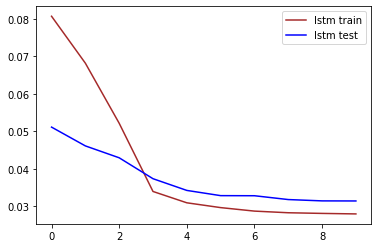

In [19]:
#dont run this cell if you are running this cell than add "validation_data=(test_X, test_y)" in model_gru.fit()
pyplot.plot(lstm_history.history['loss'], label='lstm train', color='brown')
pyplot.plot(lstm_history.history['val_loss'], label='lstm test', color='blue')
pyplot.legend()
pyplot.show()

In [20]:
test_y.reshape(2627,1)

array([[0.12032521],
       [0.13712738],
       [0.16260163],
       ...,
       [0.11327913],
       [0.05420054],
       [0.05420054]], dtype=float32)

In [21]:
pred_y

array([[0.11496536],
       [0.11698052],
       [0.13223323],
       ...,
       [0.10340337],
       [0.11451237],
       [0.06170972]], dtype=float32)

0.0032669213
0.437458157727479
0.057156987909733434
0.03140073


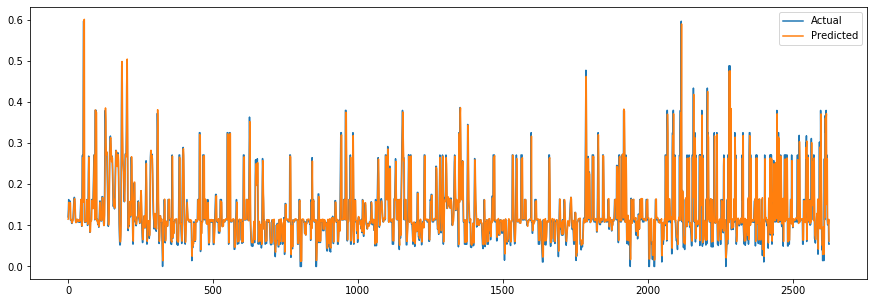

In [22]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)


print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y, label = 'Predicted')
plt.legend()
plt.show()

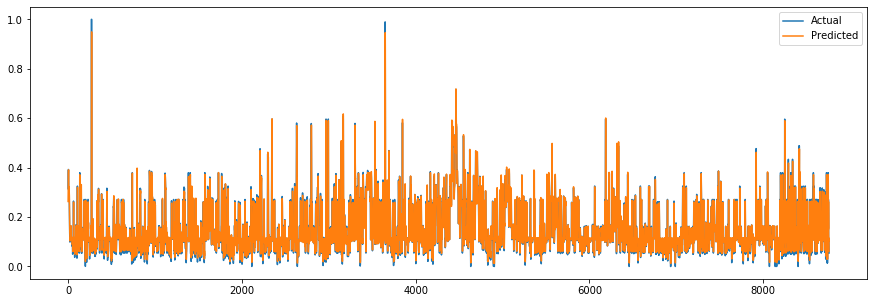

In [23]:
#visualization over full data
tra = np.concatenate([train_X,test_X])
tes = np.concatenate([train_y,test_y])
fp = model_lstm.predict(tra)
plt.plot(tes, label = 'Actual')
plt.plot(fp, label = 'Predicted')
plt.legend()
plt.show()

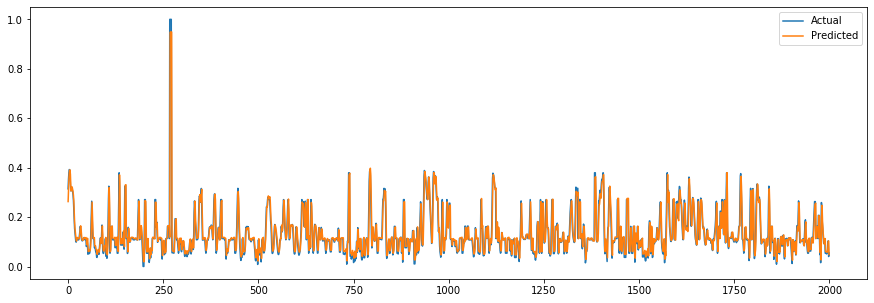

In [24]:
#over small part of data
plt.plot(tes[:2000], label = 'Actual')
plt.plot(fp[:2000], label = 'Predicted')
plt.legend()
plt.show()

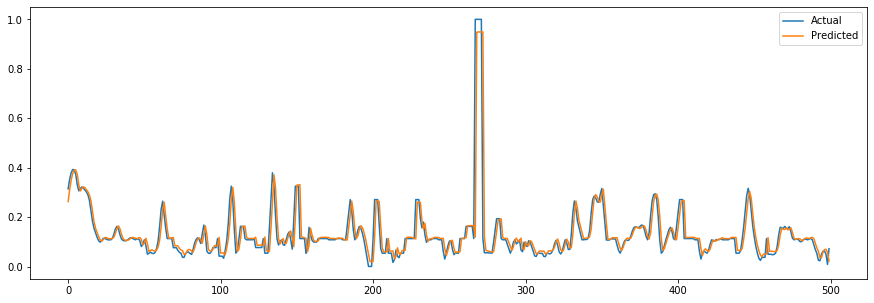

In [25]:
#over very small part of data
plt.plot(tes[:500], label = 'Actual')
plt.plot(fp[:500], label = 'Predicted')
plt.legend()
plt.show()